<a href="https://colab.research.google.com/github/AtSourav/L2-vs-L1-vs-CB-loss-in-deep-CNN-based-AE-on-cifar10/blob/main/AE_cifar10_L1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow import math
import tensorflow_datasets as tfds
from keras import losses
from keras import layers
from keras import utils
from keras import metrics
from keras import backend as K
from keras import initializers

import os
import random
import matplotlib.pyplot as plt

In [2]:
img_ht = 32
img_wd = 32

input_size = (img_ht,img_wd,3)
latent_dim = 200
batch_size = 128

initializer = initializers.HeNormal(seed=100)

# **Loading the dataset**

In [3]:
ds = tfds.load('cifar10', split='train')
ds2= tfds.load('cifar10', split='test')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incomplete3CRKP9/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incomplete3CRKP9/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [4]:
ds_to_np = list(ds.as_numpy_iterator())
ds2_to_np = list(ds2.as_numpy_iterator())

In [5]:
img_train = np.array([x['image'] for x in ds_to_np])
img_valid = np.array([x['image'] for x in ds2_to_np])

img_train = img_train/255
img_valid = img_valid/255

# **Building the model**

In [6]:
encoder_input = keras.Input(shape=input_size)

x = layers.Conv2D(64, 3, padding="valid", kernel_initializer=initializer)(encoder_input)
x = layers.ReLU()(x)

x = layers.Conv2D(64, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)

x = layers.Conv2D(128, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(128, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(128, 1, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(128, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(128, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(128, 1, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(256, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(256, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(256, 1, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(256, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(256, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(256, 1, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(512, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(512, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(512, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(512, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(512, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(512, 1, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Flatten()(x)

x = layers.Dense(3*latent_dim)(x)
x = layers.ReLU()(x)

x = layers.Dense(2*latent_dim)(x)
x = layers.ReLU()(x)


z = layers.Dense(latent_dim, name="z")(x)

encoder = keras.Model(encoder_input, z, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 64)        1792      
                                                                 
 re_lu (ReLU)                (None, 30, 30, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        16448     
                                                                 
 re_lu_1 (ReLU)              (None, 29, 29, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                           

In [7]:
latent_input = keras.Input(shape=(latent_dim,))

x = layers.Dense(2*latent_dim)(latent_input)
x = layers.ReLU()(x)

x = layers.Dense(3*latent_dim)(x)
x = layers.ReLU()(x)

x = layers.Dense(4*latent_dim)(x)
x = layers.ReLU()(x)

x = layers.Dense(2*2*1024)(x)
x = layers.ReLU()(x)

x = layers.Reshape((2,2,1024))(x)

x = layers.Conv2DTranspose(1024, 1, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(512, 1, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(512, 2, padding='valid', kernel_initializer=initializer)(x)
#x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(512, 2, padding='valid', kernel_initializer=initializer)(x)
#x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(256, 1, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(256, 2, padding='valid', kernel_initializer=initializer)(x)
#x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(256, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(256, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='bilinear')(x)

x = layers.Conv2DTranspose(128, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(128, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(128, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(128, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='bilinear')(x)

x = layers.Conv2D(128, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(128, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(128, 1, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(64, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(64, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

decoder_output = layers.Conv2D(3, 1, activation='sigmoid', padding='valid', kernel_initializer=initializer)(x)

decoder = keras.Model(latent_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 dense_2 (Dense)             (None, 400)               80400     
                                                                 
 re_lu_22 (ReLU)             (None, 400)               0         
                                                                 
 dense_3 (Dense)             (None, 600)               240600    
                                                                 
 re_lu_23 (ReLU)             (None, 600)               0         
                                                                 
 dense_4 (Dense)             (None, 800)               480800    
                                                                 
 re_lu_24 (ReLU)             (None, 800)               0   

In [8]:
decoder_out = decoder(encoder(encoder_input))
AE = keras.Model(encoder_input, decoder_out, name='AE')

AE.summary()

Model: "AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 encoder (Functional)        (None, 200)               6943472   
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         9199307   
                                                                 
Total params: 16142779 (61.58 MB)
Trainable params: 16142779 (61.58 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# **Training**

In [ ]:
K.clear_session()

In [9]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3, verbose=1, start_from_epoch=10, restore_best_weights=True)
optim = keras.optimizers.Adam(learning_rate = 0.0001)
AE.compile(optimizer=optim,loss='mae')
history = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=80, steps_per_epoch=None, callbacks=[callback])

Epoch 1/80
391/391 [==============================] - 38s 43ms/step - loss: 0.1664 - val_loss: 0.1363
Epoch 2/80
391/391 [==============================] - 11s 28ms/step - loss: 0.1289 - val_loss: 0.1213
Epoch 3/80
391/391 [==============================] - 11s 28ms/step - loss: 0.1193 - val_loss: 0.1192
Epoch 4/80
391/391 [==============================] - 11s 29ms/step - loss: 0.1161 - val_loss: 0.1183
Epoch 5/80
391/391 [==============================] - 11s 28ms/step - loss: 0.1099 - val_loss: 0.1076
Epoch 6/80
391/391 [==============================] - 11s 29ms/step - loss: 0.1038 - val_loss: 0.1023
Epoch 7/80
391/391 [==============================] - 11s 28ms/step - loss: 0.1006 - val_loss: 0.1004
Epoch 8/80
391/391 [==============================] - 11s 29ms/step - loss: 0.0984 - val_loss: 0.0979
Epoch 9/80
391/391 [==============================] - 11s 28ms/step - loss: 0.0971 - val_loss: 0.0980
Epoch 10/80
391/391 [==============================] - 11s 29ms/step - loss: 0.095

In [10]:
optim = keras.optimizers.Adam(learning_rate = 0.000075)
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3, verbose=1, start_from_epoch=1, restore_best_weights=True)
AE.compile(optimizer=optim,loss='mae')
history2 = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=80, callbacks=[callback], steps_per_epoch=None)

Epoch 1/80
391/391 [==============================] - 25s 32ms/step - loss: 0.0666 - val_loss: 0.0786
Epoch 2/80
391/391 [==============================] - 11s 29ms/step - loss: 0.0646 - val_loss: 0.0783
Epoch 3/80
391/391 [==============================] - 11s 29ms/step - loss: 0.0641 - val_loss: 0.0794
Epoch 4/80
391/391 [==============================] - 11s 29ms/step - loss: 0.0642 - val_loss: 0.0791
Epoch 5/80
391/391 [==============================] - 11s 29ms/step - loss: 0.0639 - val_loss: 0.0792
Epoch 6/80
391/391 [==============================] - 11s 29ms/step - loss: 0.0637 - val_loss: 0.0784
Epoch 7/80
391/391 [==============================] - 11s 29ms/step - loss: 0.0635 - val_loss: 0.0786
Epoch 8/80
391/391 [==============================] - 11s 28ms/step - loss: 0.0634 - val_loss: 0.0784
Epoch 9/80
391/391 [==============================] - 11s 28ms/step - loss: 0.0632 - val_loss: 0.0790
Epoch 10/80
391/391 [==============================] - 11s 29ms/step - loss: 0.063

**Overtraining!!** But we'll let it overtrain, the model does not have the necessary regularization to control that anyway. I want to see how far it can train on the training set.

In [11]:
optim = keras.optimizers.Adam(learning_rate = 0.00005)
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3, verbose=1, start_from_epoch=1, restore_best_weights=True)
AE.compile(optimizer=optim,loss='mae', metrics=['accuracy'])
history3 = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=80, callbacks=[callback], steps_per_epoch=None)

Epoch 1/80
391/391 [==============================] - 25s 32ms/step - loss: 0.0550 - accuracy: 0.7396 - val_loss: 0.0812 - val_accuracy: 0.6996
Epoch 2/80
391/391 [==============================] - 12s 30ms/step - loss: 0.0536 - accuracy: 0.7475 - val_loss: 0.0817 - val_accuracy: 0.6970
Epoch 3/80
391/391 [==============================] - 12s 30ms/step - loss: 0.0536 - accuracy: 0.7476 - val_loss: 0.0807 - val_accuracy: 0.7016
Epoch 4/80
391/391 [==============================] - 12s 30ms/step - loss: 0.0534 - accuracy: 0.7480 - val_loss: 0.0811 - val_accuracy: 0.7011
Epoch 5/80
391/391 [==============================] - 12s 30ms/step - loss: 0.0533 - accuracy: 0.7479 - val_loss: 0.0814 - val_accuracy: 0.7007
Epoch 6/80
391/391 [==============================] - 12s 29ms/step - loss: 0.0533 - accuracy: 0.7483 - val_loss: 0.0809 - val_accuracy: 0.7014
Epoch 7/80
391/391 [==============================] - 12s 30ms/step - loss: 0.0532 - accuracy: 0.7480 - val_loss: 0.0812 - val_accuracy:

In [12]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.00001, decay_steps=1564, decay_rate=0.95)
optim = keras.optimizers.Adam(learning_rate = lr_schedule)
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3, verbose=1, start_from_epoch=1, restore_best_weights=True)
AE.compile(optimizer=optim,loss='mae', metrics=['accuracy'])
history4 = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=100, callbacks=[callback], steps_per_epoch=None)

Epoch 1/100
391/391 [==============================] - 25s 33ms/step - loss: 0.0478 - accuracy: 0.7599 - val_loss: 0.0834 - val_accuracy: 0.7038
Epoch 2/100
391/391 [==============================] - 11s 29ms/step - loss: 0.0474 - accuracy: 0.7605 - val_loss: 0.0835 - val_accuracy: 0.7038
Epoch 3/100
391/391 [==============================] - 11s 29ms/step - loss: 0.0472 - accuracy: 0.7607 - val_loss: 0.0837 - val_accuracy: 0.7040
Epoch 4/100
391/391 [==============================] - 12s 29ms/step - loss: 0.0471 - accuracy: 0.7609 - val_loss: 0.0836 - val_accuracy: 0.7023
Epoch 5/100
391/391 [==============================] - 11s 29ms/step - loss: 0.0470 - accuracy: 0.7610 - val_loss: 0.0837 - val_accuracy: 0.7020
Epoch 6/100
391/391 [==============================] - 11s 29ms/step - loss: 0.0470 - accuracy: 0.7610 - val_loss: 0.0837 - val_accuracy: 0.7029
Epoch 7/100
391/391 [==============================] - 12s 30ms/step - loss: 0.0469 - accuracy: 0.7611 - val_loss: 0.0839 - val_ac

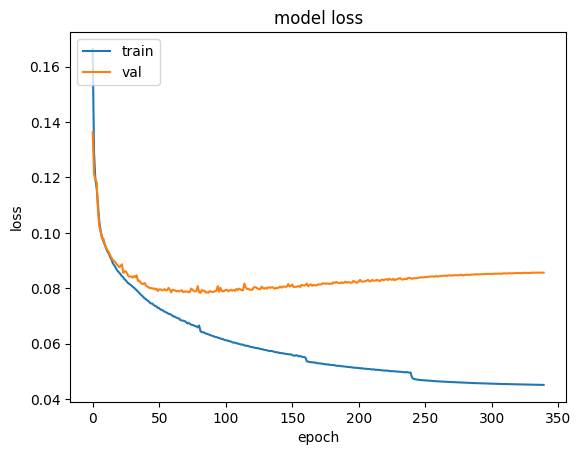

In [13]:
plt.plot(history.history['loss']+history2.history['loss']+history3.history['loss']+history4.history['loss'])
plt.plot(history.history['val_loss']+history2.history['val_loss']+history3.history['val_loss']+history4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# **Plotting some of the original images and the corresponding reconstructions**

In [14]:
def plot_reconstruction(set, name,seed_val, epochs):     #name should be either 'training' or 'validation'
  np.random.seed(seed_val)

  tg_indices = np.random.randint(0,set.shape[0],size = 16)
  img_sample = tf.convert_to_tensor(np.array(set)[tg_indices])
  z_sample = encoder(img_sample)
  img_recon = decoder(z_sample)

  recon = plt.figure(figsize=(9,4))
  recon.suptitle('Reconstructed images (right) from the ' + name + '-set after ' + str(epochs) + ' epochs: latent_dim =' + str(latent_dim), fontweight= 'bold', y=0.93)

  recon.tight_layout()

  for i in range(36):
    recon.add_subplot(4,9,i+1)
    j = int(np.floor(i/9))
    if (i%9) <4:
      img = set[tg_indices[j*4 + (i%9)]]
      plt.imshow(img)
      plt.axis('off')
    elif (i%9)==4:
      img = np.ones((32,32,3))
      plt.imshow(img)
      plt.axis('off')
    else:
      img = img_recon[j*4 + (i%9) - 5]
      plt.imshow(img)
      plt.axis('off')

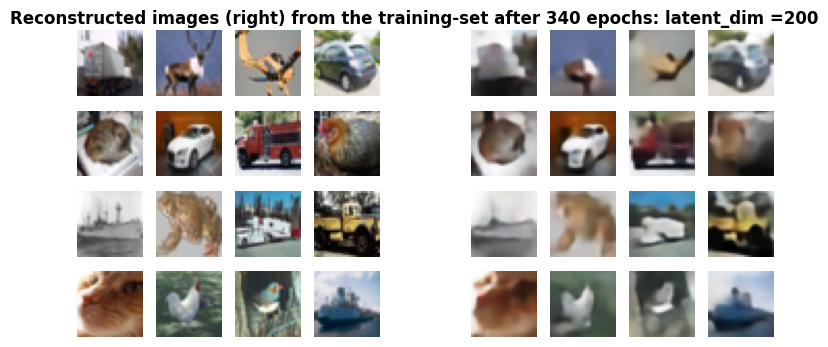

In [15]:
plot_reconstruction(img_train, 'training',123,340)

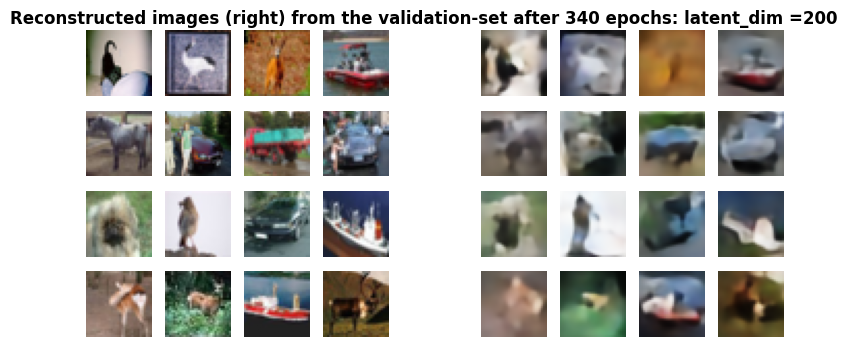

In [16]:
plot_reconstruction(img_valid,'validation',123,340)

We waited for the network (with the same architecture that we optimised with mse loss) to start overtraining and then the results are above. The reconstructed images have equally good colour depth as with mse loss, but they are even more blurry it seems. So at least from these experiments mse or CB loss seem to be better options than L1 loss.